<a href="https://colab.research.google.com/github/AJ125000/Diabetes_prediction_from_medical_records/blob/main/Diabetes_prediction_from_medical_records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import catboost as cb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diabetes prediction/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diabetes prediction/test.csv')

In [ ]:
train_data.isnull().sum()

Id                          0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        550 non-null    int64  
 1   Pregnancies               550 non-null    int64  
 2   Glucose                   550 non-null    int64  
 3   BloodPressure             550 non-null    int64  
 4   SkinThickness             550 non-null    int64  
 5   Insulin                   550 non-null    int64  
 6   BMI                       550 non-null    float64
 7   DiabetesPedigreeFunction  550 non-null    float64
 8   Age                       550 non-null    int64  
 9   Outcome                   550 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 43.1 KB


In [ ]:
train_data.nunique()

Id                          550
Pregnancies                  17
Glucose                     124
BloodPressure                41
SkinThickness                50
Insulin                     157
BMI                         221
DiabetesPedigreeFunction    404
Age                          52
Outcome                       2
dtype: int64

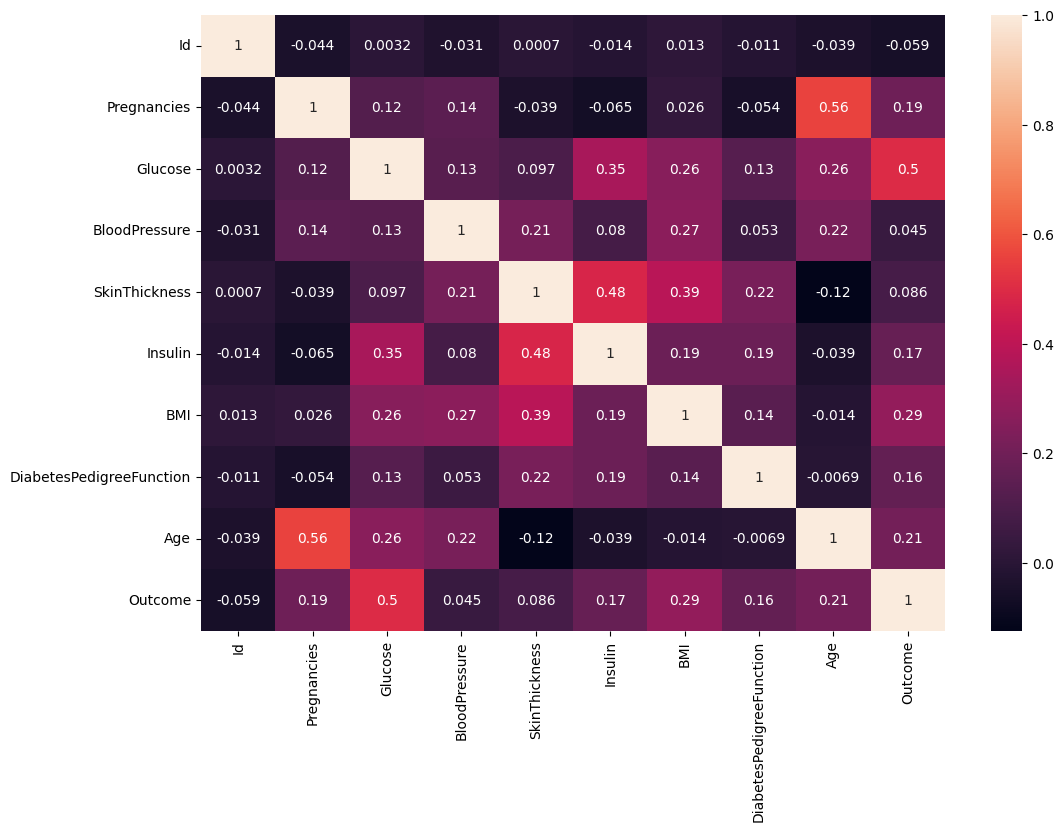

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), annot=True)
plt.show()

In [ ]:
train_data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Id,550.0,379.630909,222.127731,1.000,187.25000,377.500,571.50000,766.00
Pregnancies,550.0,4.034545,3.447325,0.000,1.00000,3.000,6.00000,17.00
Glucose,550.0,121.560000,30.551206,0.000,100.00000,119.000,141.00000,197.00
BloodPressure,550.0,69.381818,19.036147,0.000,62.00000,72.000,80.00000,122.00
SkinThickness,550.0,20.014545,15.898006,0.000,0.00000,22.000,32.00000,63.00
Insulin,550.0,80.141818,115.429640,0.000,0.00000,22.500,128.75000,846.00
BMI,550.0,31.902000,7.822178,0.000,27.20000,32.000,36.50000,59.40
DiabetesPedigreeFunction,550.0,0.466582,0.320054,0.078,0.23925,0.375,0.62825,2.42
Age,550.0,33.590909,12.054140,21.000,24.00000,29.000,41.00000,81.00
Outcome,550.0,0.354545,0.478811,0.000,0.00000,0.000,1.00000,1.00


Id
Skew : 0.03


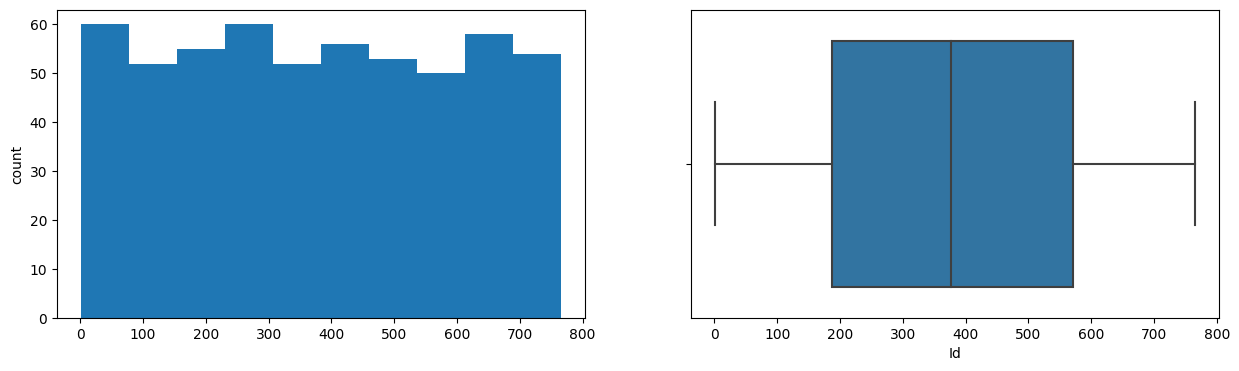

Pregnancies
Skew : 0.84


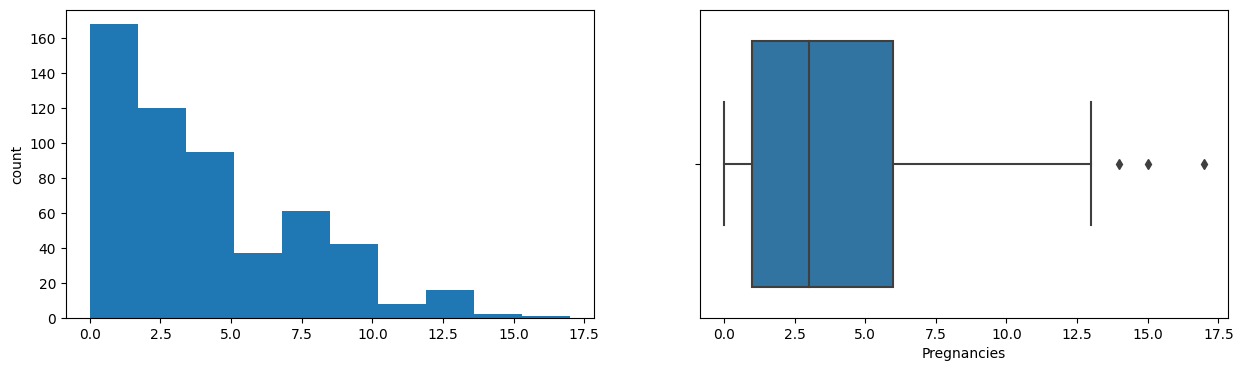

Glucose
Skew : 0.23


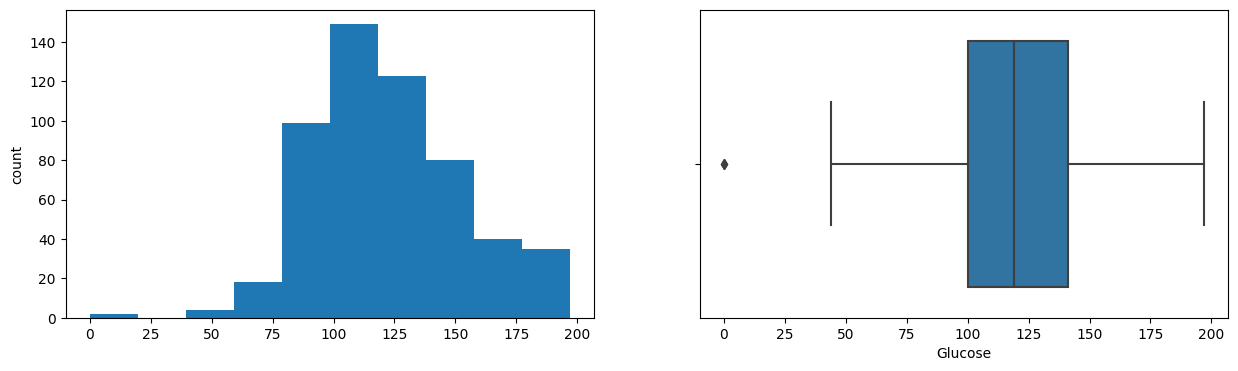

BloodPressure
Skew : -1.82


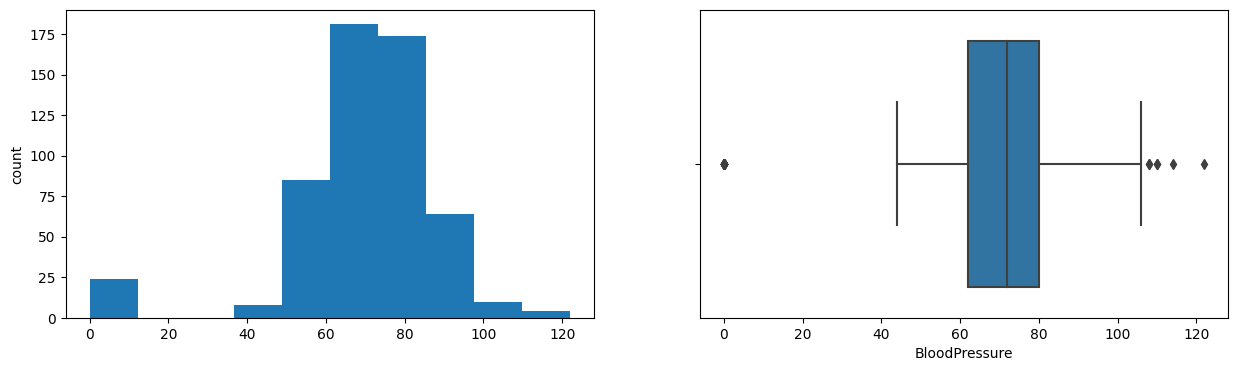

SkinThickness
Skew : 0.02


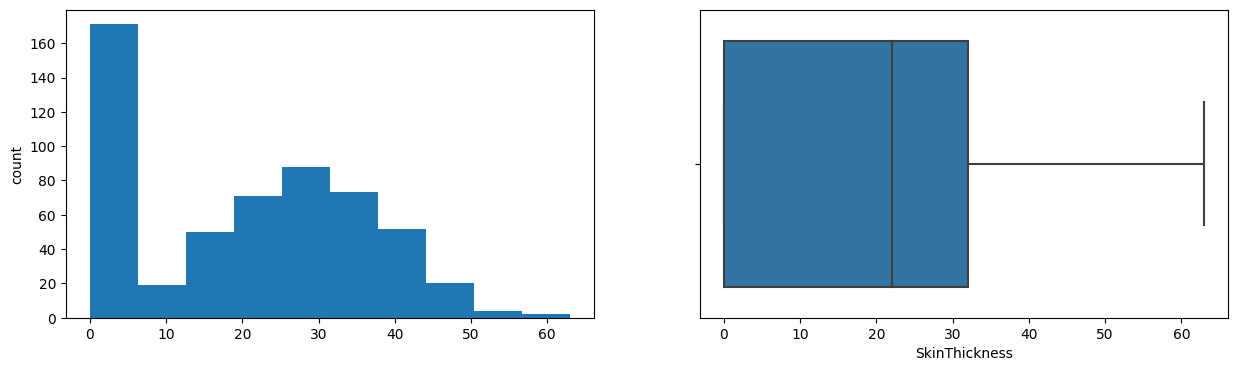

Insulin
Skew : 2.18


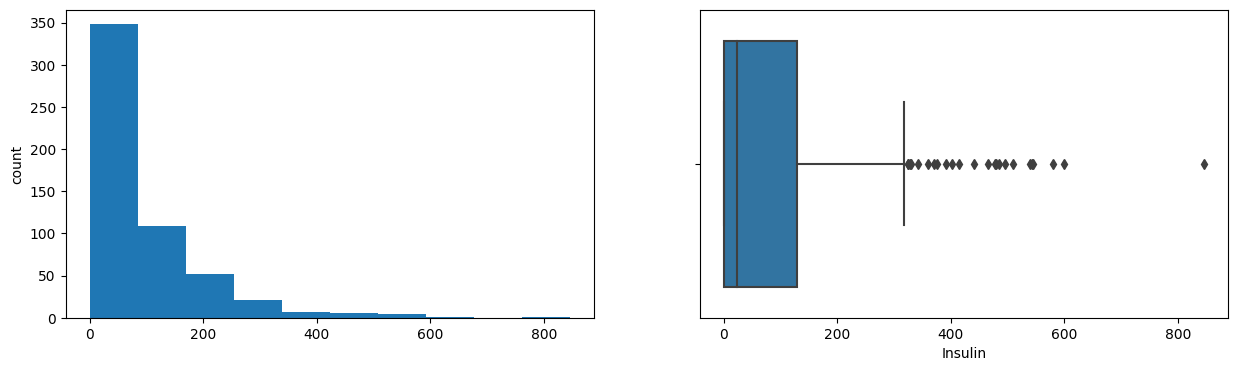

BMI
Skew : -0.52


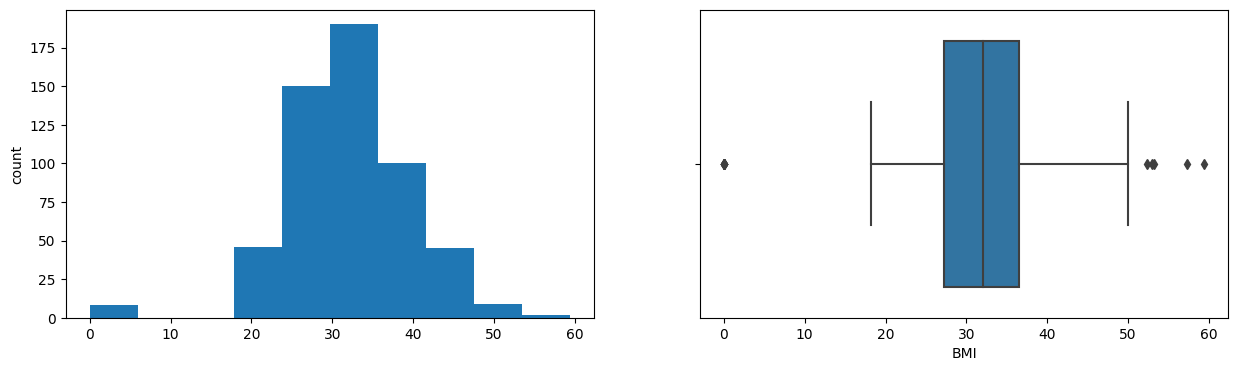

DiabetesPedigreeFunction
Skew : 1.85


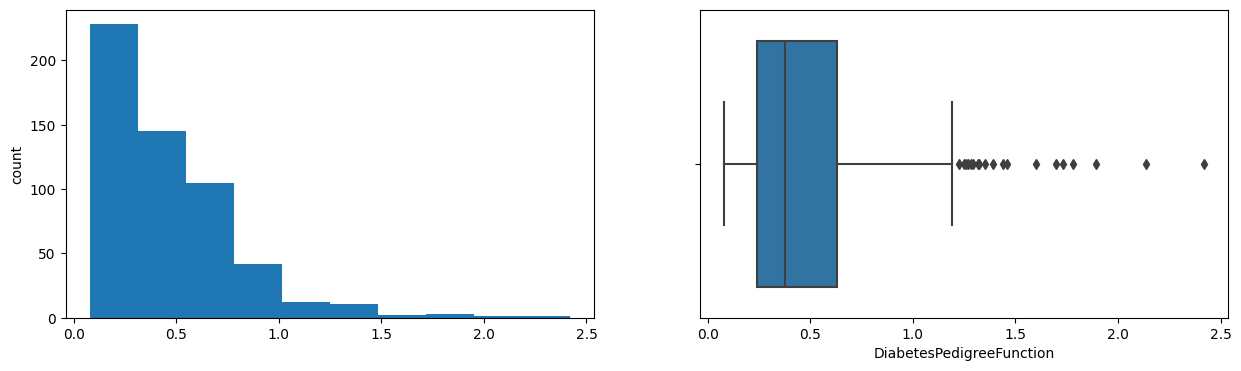

Age
Skew : 1.13


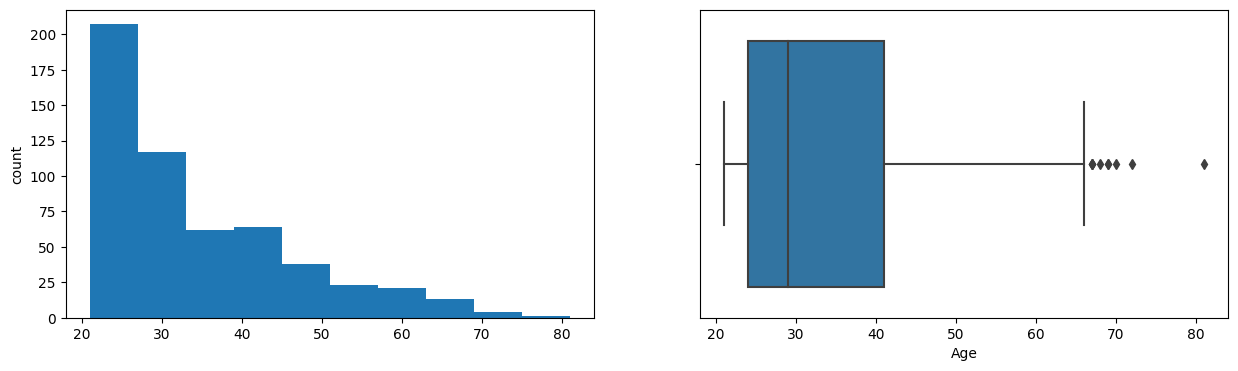

Outcome
Skew : 0.61


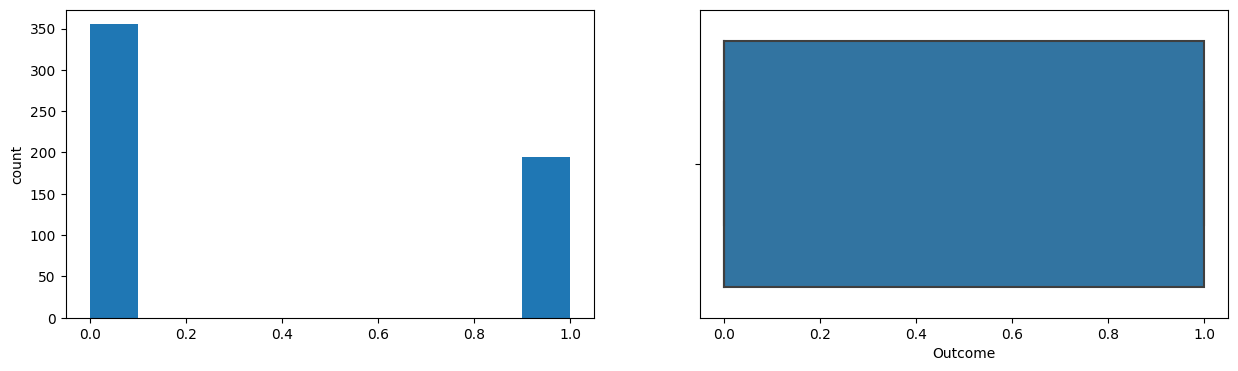

In [ ]:
cols = train_data.columns.to_list()

for col in cols:
    print(col)
    print('Skew :', round(train_data[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    train_data[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x= train_data[col])
    plt.show()

In [ ]:
def log_transform(data,col):
    for colname in col:
        if (data[colname] == 1.0).all():
            data[colname + '_log'] = np.log(data[colname]+1)
        else:
            data[colname + '_log'] = np.log(data[colname])
    data.info()

def sqrt_tranform(data,col):
    for colname in col:
      data[colname+'_sqrt'] = np.sqrt(data[colname])
    data.info()

In [ ]:
log_transform(train_data,['Pregnancies','Insulin','DiabetesPedigreeFunction','Age'])
sqrt_tranform(train_data, ['BloodPressure','BMI'] )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            550 non-null    int64  
 1   Pregnancies                   550 non-null    int64  
 2   Glucose                       550 non-null    int64  
 3   BloodPressure                 550 non-null    int64  
 4   SkinThickness                 550 non-null    int64  
 5   Insulin                       550 non-null    int64  
 6   BMI                           550 non-null    float64
 7   DiabetesPedigreeFunction      550 non-null    float64
 8   Age                           550 non-null    int64  
 9   Outcome                       550 non-null    int64  
 10  Pregnancies_log               550 non-null    float64
 11  Insulin_log                   550 non-null    float64
 12  DiabetesPedigreeFunction_log  550 non-null    float64
 13  Age_l

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
train_data_final = train_data.iloc[:, 0:10]
train_data_final

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,1,85,66,29,0,26.6,0.351,31,0
1,3,1,89,66,23,94,28.1,0.167,21,0
2,5,5,116,74,0,0,25.6,0.201,30,0
3,7,10,115,0,0,0,35.3,0.134,29,0
4,8,2,197,70,45,543,30.5,0.158,53,1
...,...,...,...,...,...,...,...,...,...,...
545,761,9,170,74,31,0,44.0,0.403,43,1
546,762,9,89,62,0,0,22.5,0.142,33,0
547,763,10,101,76,48,180,32.9,0.171,63,0
548,764,2,122,70,27,0,36.8,0.340,27,0


In [ ]:
x_train = train_data_final.iloc[:,0:9]
y_train = train_data_final.loc[:,'Outcome']
x_train


,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,1,85,66,29,0,26.6,0.351,31
1,3,1,89,66,23,94,28.1,0.167,21
2,5,5,116,74,0,0,25.6,0.201,30
3,7,10,115,0,0,0,35.3,0.134,29
4,8,2,197,70,45,543,30.5,0.158,53
...,...,...,...,...,...,...,...,...,...
545,761,9,170,74,31,0,44.0,0.403,43
546,762,9,89,62,0,0,22.5,0.142,33
547,763,10,101,76,48,180,32.9,0.171,63
548,764,2,122,70,27,0,36.8,0.340,27


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)


In [ ]:
test_data

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,6,148,72,35,0,33.6,0.627,50
1,2,8,183,64,0,0,23.3,0.672,32
2,4,0,137,40,35,168,43.1,2.288,33
3,6,3,78,50,32,88,31.0,0.248,26
4,15,7,100,0,0,0,30.0,0.484,32
...,...,...,...,...,...,...,...,...,...
213,739,1,102,74,0,0,39.5,0.293,42
214,752,3,108,62,24,0,26.0,0.223,25
215,759,6,190,92,0,0,35.5,0.278,66
216,765,5,121,72,23,112,26.2,0.245,30


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(n_estimators=100)
model1.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
# calculate the accuracy of model

score = model1.score(x_test, y_test)
print('Accuracy:', score)


Accuracy: 0.7101449275362319


In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train)
xgb_score = xgb_model.score(x_test, y_test)
print('XGBoost Accuracy:', xgb_score)



XGBoost Accuracy: 0.7246376811594203


In [ ]:
cat_model = cb.CatBoostClassifier(iterations=100)
cat_model.fit(x_train, y_train)
cat_score = cat_model.score(x_test, y_test)
print('CatBoost Accuracy:', cat_score)


Learning rate set to 0.058277
0:	learn: 0.6795179	total: 49.1ms	remaining: 4.86s
1:	learn: 0.6662082	total: 50.8ms	remaining: 2.49s
2:	learn: 0.6546542	total: 52.2ms	remaining: 1.69s
3:	learn: 0.6437807	total: 53.6ms	remaining: 1.29s
4:	learn: 0.6329771	total: 55ms	remaining: 1.04s
5:	learn: 0.6239542	total: 56.3ms	remaining: 882ms
6:	learn: 0.6139289	total: 58.6ms	remaining: 779ms
7:	learn: 0.6042686	total: 60.6ms	remaining: 697ms
8:	learn: 0.5953744	total: 61.8ms	remaining: 624ms
9:	learn: 0.5853454	total: 63.1ms	remaining: 568ms
10:	learn: 0.5779927	total: 64.4ms	remaining: 521ms
11:	learn: 0.5710122	total: 66.1ms	remaining: 484ms
12:	learn: 0.5629299	total: 67.5ms	remaining: 452ms
13:	learn: 0.5565673	total: 68.9ms	remaining: 423ms
14:	learn: 0.5499499	total: 72.1ms	remaining: 408ms
15:	learn: 0.5438988	total: 73.5ms	remaining: 386ms
16:	learn: 0.5373556	total: 74.8ms	remaining: 365ms
17:	learn: 0.5316952	total: 76.2ms	remaining: 347ms
18:	learn: 0.5247333	total: 77.6ms	remaining: 

In [ ]:
parameters = {'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 5, 7],
              'iterations': [100, 200, 300]}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(cat_model, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print('Best model:', best_model)
print('Best score:', best_score)

best_model.fit(x_train, y_train)
best_score_on_test = best_model.score(x_test, y_test)
print('Best score on test set:', best_score_on_test)


0:	learn: 0.6892523	total: 1.03ms	remaining: 309ms
1:	learn: 0.6859306	total: 2.52ms	remaining: 375ms
2:	learn: 0.6831603	total: 3.54ms	remaining: 351ms
3:	learn: 0.6792069	total: 4.48ms	remaining: 332ms
4:	learn: 0.6751996	total: 5.34ms	remaining: 315ms
5:	learn: 0.6723212	total: 6.14ms	remaining: 301ms
6:	learn: 0.6687961	total: 6.94ms	remaining: 291ms
7:	learn: 0.6657350	total: 7.74ms	remaining: 283ms
8:	learn: 0.6619153	total: 8.55ms	remaining: 277ms
9:	learn: 0.6598770	total: 9.48ms	remaining: 275ms
10:	learn: 0.6562425	total: 10.4ms	remaining: 272ms
11:	learn: 0.6522883	total: 11.2ms	remaining: 269ms
12:	learn: 0.6479191	total: 12.1ms	remaining: 267ms
13:	learn: 0.6437915	total: 12.9ms	remaining: 264ms
14:	learn: 0.6392769	total: 13.8ms	remaining: 263ms
15:	learn: 0.6355812	total: 14.7ms	remaining: 262ms
16:	learn: 0.6329319	total: 15.6ms	remaining: 260ms
17:	learn: 0.6299862	total: 16.4ms	remaining: 257ms
18:	learn: 0.6267913	total: 17.3ms	remaining: 256ms
19:	learn: 0.6229969	t

In [ ]:
predictions = best_model.predict(test_data)

In [ ]:
predictions_df = pd.DataFrame({'Prediction': predictions})
predictions_df.to_csv('submission1.csv', index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_score = logreg.score(x_test, y_test)
print('Logistic Regression Accuracy:', logreg_score)

Logistic Regression Accuracy: 0.7318840579710145


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:

from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Create the model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=9,))
model.add(Dense(units=128, activation='relu',  kernel_regularizer='l2'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=100)

# Evaluate the model
model.evaluate(x_test, y_test)

# Save the model
model.save('my_model.h5')

Epoch 1/100
13/13 [==============================] - 2s 6ms/step - loss: 5.3431 - accuracy: 0.6092
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 4.0007 - accuracy: 0.6141
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 2.7775 - accuracy: 0.6238
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 2.0169 - accuracy: 0.6675
Epoch 5/100
13/13 [==============================] - 0s 6ms/step - loss: 2.3483 - accuracy: 0.6383
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 1.9026 - accuracy: 0.6238
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 2.1901 - accuracy: 0.6529
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 2.3556 - accuracy: 0.6044
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 2.2760 - accuracy: 0.6553
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 1.8303 - accuracy: 0.6432
Epoch 11/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            550 non-null    int64  
 1   Pregnancies                   550 non-null    int64  
 2   Glucose                       550 non-null    int64  
 3   BloodPressure                 550 non-null    int64  
 4   SkinThickness                 550 non-null    int64  
 5   Insulin                       550 non-null    int64  
 6   BMI                           550 non-null    float64
 7   DiabetesPedigreeFunction      550 non-null    float64
 8   Age                           550 non-null    int64  
 9   Outcome                       550 non-null    int64  
 10  Pregnancies_log               550 non-null    float64
 11  Insulin_log                   550 non-null    float64
 12  DiabetesPedigreeFunction_log  550 non-null    float64
 13  Age_l

In [ ]:
# prompt: save column 0,2,4,10,11,12,13,14 and 15 to x_train2 dataframe using iloc

x2 = train_data.iloc[:, [0,2,4,5,10,12,13,14,15]]

y2 = train_data_final.loc[:,'Outcome']
x2

,Id,Glucose,SkinThickness,Insulin,Pregnancies_log,DiabetesPedigreeFunction_log,Age_log,BloodPressure_sqrt,BMI_sqrt
0,1,85,29,0,0.000000,-1.046969,3.433987,8.124038,5.157519
1,3,89,23,94,0.000000,-1.789761,3.044522,8.124038,5.300943
2,5,116,0,0,1.609438,-1.604450,3.401197,8.602325,5.059644
3,7,115,0,0,2.302585,-2.009915,3.367296,0.000000,5.941380
4,8,197,45,543,0.693147,-1.845160,3.970292,8.366600,5.522681
...,...,...,...,...,...,...,...,...,...
545,761,170,31,0,2.197225,-0.908819,3.761200,8.602325,6.633250
546,762,89,0,0,2.197225,-1.951928,3.496508,7.874008,4.743416
547,763,101,48,180,2.302585,-1.766092,4.143135,8.717798,5.735852
548,764,122,27,0,0.693147,-1.078810,3.295837,8.366600,6.066300


In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.25, random_state = 42)

In [ ]:
x_test2

,Id,Glucose,SkinThickness,Insulin,Pregnancies_log,DiabetesPedigreeFunction_log,Age_log,BloodPressure_sqrt,BMI_sqrt
195,269,146,0,0,0.693147,-1.427116,3.332205,0.000000,5.244044
79,108,83,31,18,1.098612,-1.090644,3.218876,7.615773,5.856620
480,669,154,30,100,2.197225,-1.807889,3.806662,8.831761,5.558777
109,149,90,17,0,0.693147,-2.465104,3.091042,8.366600,5.224940
522,730,130,23,79,1.098612,-1.130103,3.526361,8.831761,5.329165
...,...,...,...,...,...,...,...,...,...
398,550,116,28,0,0.000000,-1.589635,3.044522,8.366600,5.234501
69,93,134,0,0,1.386294,-1.283738,4.094345,8.485281,4.878524
261,360,189,33,325,1.609438,-0.539568,3.367296,8.000000,5.585696
517,723,117,30,105,1.609438,-1.382302,3.737670,9.273618,6.252999


In [ ]:
cat_model = cb.CatBoostClassifier(iterations=100)
cat_model.fit(x_train2, y_train2)
cat_score2 = cat_model.score(x_test2, y_test2)
print('CatBoost Accuracy:', cat_score2)


Learning rate set to 0.058277
0:	learn: 0.6801650	total: 3.83ms	remaining: 380ms
1:	learn: 0.6661549	total: 6.02ms	remaining: 295ms
2:	learn: 0.6547063	total: 7.29ms	remaining: 236ms
3:	learn: 0.6417875	total: 8.32ms	remaining: 200ms
4:	learn: 0.6301074	total: 10.2ms	remaining: 194ms
5:	learn: 0.6192361	total: 11.9ms	remaining: 186ms
6:	learn: 0.6100826	total: 13ms	remaining: 172ms
7:	learn: 0.6020354	total: 14ms	remaining: 161ms
8:	learn: 0.5928753	total: 15.1ms	remaining: 153ms
9:	learn: 0.5845193	total: 16.5ms	remaining: 148ms
10:	learn: 0.5749459	total: 18.2ms	remaining: 147ms
11:	learn: 0.5701469	total: 20ms	remaining: 146ms
12:	learn: 0.5631455	total: 21ms	remaining: 140ms
13:	learn: 0.5557925	total: 22ms	remaining: 135ms
14:	learn: 0.5493388	total: 23.1ms	remaining: 131ms
15:	learn: 0.5426316	total: 24.2ms	remaining: 127ms
16:	learn: 0.5368926	total: 25.4ms	remaining: 124ms
17:	learn: 0.5310759	total: 27.2ms	remaining: 124ms
18:	learn: 0.5260950	total: 29.1ms	remaining: 124ms
19